In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
np.set_printoptions(suppress=True, linewidth=200)

In [2]:
# data=np.load("./data/250_50_sdf_based_collision.npz")
data=np.load("./data/10000_50_collision.npz")

In [3]:
sdf = np.load("./data/obstacles_1_sdf.npz")
sdf = sdf['sdf'].squeeze()

In [4]:
actions = data['actions']
states = data['states']
tail = data['states'][:, :, 0:2]
mid = data['states'][:, :, 2:4]
head = data['states'][:, :, 4:6]
constraints = data['constraints']

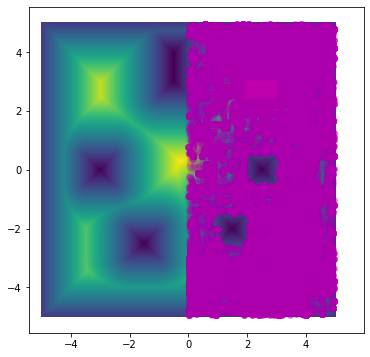

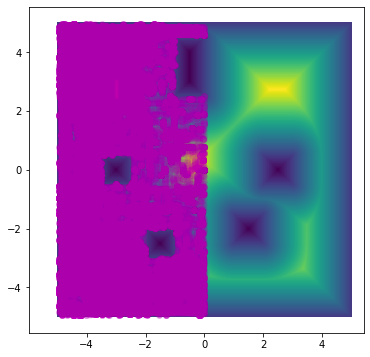

In [17]:
# create a held-out set with only points where tail x > 0
right_half_data_states = []
right_half_data_actions = []
right_half_data_constraints = []
left_half_data_states = []
left_half_data_actions = []
left_half_data_constraints = []
for state_traj, u_traj, k_traj in zip(states, actions, constraints):
    for state, u, k in zip(state_traj, u_traj, k_traj):
        if state[0] > 0:
            right_half_data_states.append(state)
            right_half_data_actions.append(u)
            right_half_data_constraints.append(k)
        else:
            left_half_data_states.append(state)
            left_half_data_actions.append(u)
            left_half_data_constraints.append(k)
            
np.savez("./data/right_half_data_collision.npz", states=right_half_data_states, actions=right_half_data_actions, constraints=right_half_data_constraints)
np.savez("./data/left_half_data_collision.npz", states=left_half_data_states, actions=left_half_data_actions, constraints=left_half_data_constraints)

right_half_data = np.load("./data/right_half_data_collision.npz")
plt.figure(figsize=(6,6))
plt.imshow(np.flipud(sdf.T), extent=[-5,5,-5,5])
plt.scatter(right_half_data['states'][:,0], right_half_data['states'][:,1], c='m', alpha=0.05)
plt.axis("equal");

left_half_data = np.load("./data/left_half_data_collision.npz")
plt.figure(figsize=(6,6))
plt.imshow(np.flipud(sdf.T), extent=[-5,5,-5,5])
plt.scatter(left_half_data['states'][:,0], left_half_data['states'][:,1], c='g', alpha=0.05)
plt.axis("equal");

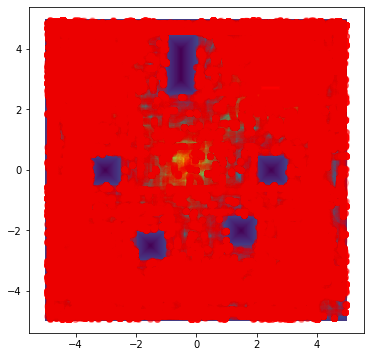

In [6]:
# show all location of the tail overlayed on the SDF
plt.figure(figsize=(6,6))
plt.imshow(np.flipud(sdf.T), extent=[-5,5,-5,5])
plt.scatter(tail[:,:,0], tail[:,:,1], c='r', alpha=0.05)
plt.axis("equal");

(-4.927598442498087,
 -3.959939277670716,
 -4.789959160317708,
 -3.0543179053417173)

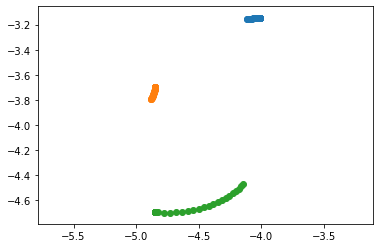

In [7]:
worst_idx = 179
plt.scatter(tail[worst_idx,:,0], tail[worst_idx,:,1])
plt.scatter(mid[worst_idx,:,0], mid[worst_idx,:,1])
plt.scatter(head[worst_idx,:,0], head[worst_idx,:,1])
plt.axis("equal")

In [8]:
def make_constraint_mask(arr, axis=1):
    """ takes in a 2d array and returns two lists of indeces all elements before the first constriant violation """
    # arr = arr.squeeze()
    invalid_val = arr.shape[1]
    mask = arr != 0
    indeces_of_first_violation = np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)
    batch_indeces = []
    time_indeces = []
    for batch_index, index_of_first_violation in enumerate(indeces_of_first_violation):
        for index_with_no_violation in range(index_of_first_violation):
            batch_indeces.append(batch_index)
            time_indeces.append(index_with_no_violation)

    return batch_indeces, time_indeces 

In [13]:
def plot(traj_idx):
    bi, ti = make_constraint_mask(np.expand_dims(constraints[traj_idx], axis=0))
    bi = np.ones_like(bi) * traj_idx
    head_no_collision = np.expand_dims(head[bi, ti], axis=0)
    plt.figure(figsize=(6,6))
    plt.imshow(np.flipud(sdf.T), extent=[-5,5,-5,5])
    plt.scatter(head[traj_idx,:,0], head[traj_idx,:,1], c='k', s=50)
    plt.scatter(mid[traj_idx,:,0], mid[traj_idx,:,1], c='r', s=50)
    plt.scatter(tail[traj_idx,:,0], tail[traj_idx,:,1], c='m', s=10)
    c = cm.rainbow(np.linspace(0, 1, len(head_no_collision[0])))
    p = head[traj_idx,0]
    predictions = []
    dp = np.dot(np.eye(2), actions[traj_idx,0]) * 0.1 * 0.73
    for t in range(50):
        predictions.append(p)
        p = p + dp
    predictions = np.array(predictions)
    plt.scatter(predictions[:,0], predictions[:,1], s=15)
    plt.scatter(head_no_collision[0,:,0], head_no_collision[0,:,1], c=c, s=10)
        
    plt.axis("equal");

In [14]:
plot(179)

TypeError: only integer scalar arrays can be converted to a scalar index